In [1]:
# prefix_converter.py
import re
import json
from sympy import sympify
from sympy.parsing.sympy_parser import parse_expr

def extract_scrambled_expressions(file_path):
    """
    从文件中提取Scrambled expression开头之后的表达式
    """
    expressions = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.startswith("Scrambled expression :"):
                expr = line.strip().split(":", 1)[1].strip()
                expressions.append(expr)
    return expressions

def extract_polylog_terms(expr_str):
    """
    提取 polylog(2, ...) 项，并带上前面的系数。
    返回结构为：[(系数, 参数表达式)](默认为Li_2)
    """
    pattern = r'([+\-]?\s*\d*\.?\d*)\*?polylog\(2,\s*(.*?)\)'
    matches = re.findall(pattern, expr_str)
    terms = []
    for coeff, arg in matches:
        coeff = coeff.replace(" ", "")
        coeff = coeff if coeff not in ['', '+', '-'] else coeff + '1'
        terms.append((coeff, arg))
    return terms

def build_prefix(tokens):
    return ['add'] + tokens

def generate_prefix(expr_str):
    terms = extract_polylog_terms(expr_str)
    prefix_expr = []
    for coeff, arg in terms:
        # 前缀形式为：mul, 系数, polylog, 2, 参数
        prefix_expr.extend(['mul', coeff, 'polylog', '2', arg])
    return build_prefix(prefix_expr)

if __name__ == '__main__':
    expressions = extract_scrambled_expressions("rl_data_dilogs/test_data.txt")
    all_prefixes = [generate_prefix(expr) for expr in expressions]

    # 输出前 3 个示例
    for i, prefix in enumerate(all_prefixes[:3]):
        print(f"Example {i+1}:")
        print(prefix)
        print()

    # 保存为 JSON 文件
    with open("prefix_expressions.json", "w", encoding="utf-8") as f:
        json.dump(all_prefixes, f, indent=2, ensure_ascii=False)


Example 1:
['add', 'mul', '-6', 'polylog', '2', 'x', 'mul', '-2', 'polylog', '2', '(-2*x**2 - 2*x + 1', 'mul', '-2', 'polylog', '2', '(2*x**2 + 2*x - 1', 'mul', '+6', 'polylog', '2', 'x - 1', 'mul', '-3', 'polylog', '2', 'x**2 - 2*x + 1']

Example 2:
['add', 'mul', '-3', 'polylog', '2', '2*x', 'mul', '-3', 'polylog', '2', '1/(2*x - 1', 'mul', '-7', 'polylog', '2', '-2/(x**2 - 2', 'mul', '-7', 'polylog', '2', '2/(x**2 - 2', 'mul', '+3', 'polylog', '2', '1/(4*x**2 - 4*x + 1', 'mul', '-7', 'polylog', '2', 'x**4/4 - x**2 + 1']

Example 3:
['add', 'mul', '-1', 'polylog', '2', '(x**4 + 4*x**2 + 4', 'mul', '-1', 'polylog', '2', '-x/(x**2 + 2', 'mul', '-1', 'polylog', '2', 'x/(x**2 + 2', 'mul', '-2', 'polylog', '2', '-2*x**2 - 2*x + 1', 'mul', '+2', 'polylog', '2', '1/(2*x**2 + 2*x - 1', 'mul', '+1', 'polylog', '2', '4*x**4 + 8*x**3 - 4*x + 1']



In [2]:
import numpy as np
import json
from sympy import sympify
from sympy.core import Symbol, Function, Add, Mul, Pow

# 词表：包括负常数 -10 到 9
# 定义词表
vocab = ['add', 'mul', 'polylog', '+', '*', '**', 'x'] + [str(i) for i in range(-10, 10)]

# token → id 映射
token_to_id = {token: idx for idx, token in enumerate(vocab)}

# id → token 映射（反向映射）
id_to_token = {idx: token for token, idx in token_to_id.items()}

vocab_size = len(vocab)
L_max = 64  # 最大 token 长度

def flatten_expr(expr):
    """递归地将 sympy 表达式转换为 prefix token 列表"""
    if expr.is_Symbol:
        return [str(expr)]
    elif expr.is_Number:
        return [str(expr)]
    elif isinstance(expr, Pow):
        base, exp = expr.args
        return ['**'] + flatten_expr(base) + flatten_expr(exp)
    elif isinstance(expr, Mul):
        def binary_mul(args):
            if len(args) == 1:
                return flatten_expr(args[0])
            else:
                return ['*'] + flatten_expr(args[0]) + binary_mul(args[1:])
        return binary_mul(list(expr.args))
    elif isinstance(expr, Add):
        tokens = ['+']
        for arg in expr.args:
            tokens += flatten_expr(arg)
        return tokens
    elif expr.func.__name__ == 'polylog':
        n, arg = expr.args
        return ['polylog', str(n)] + flatten_expr(arg)
    else:
        return [str(expr)]

def tokenize_prefix(prefix_expr):
    """使用 sympy 将 prefix 中的参数进一步拆分成基本操作 token"""
    tokens = []
    for token in prefix_expr:
        try:
            parsed = sympify(token)
            tokens += flatten_expr(parsed)
        except Exception:
            tokens.append(token)
    return tokens

def prefix_to_onehot(prefix_expr):
    tokens = tokenize_prefix(prefix_expr)
    onehots = np.zeros((L_max, vocab_size), dtype=np.float32)
    for i, token in enumerate(tokens[:L_max]):
        if token in token_to_id:
            onehots[i, token_to_id[token]] = 1.0
    return onehots

def encode_all_from_json(json_path, output_path):
    with open(json_path, 'r', encoding='utf-8') as f:
        prefix_data = json.load(f)
    all_onehots = np.stack([prefix_to_onehot(expr) for expr in prefix_data])
    np.save(output_path, all_onehots)
    print(f"Saved {len(all_onehots)} one-hot encoded expressions to {output_path}")

if __name__ == '__main__':
    # 示例用法：从 JSON 加载并编码所有表达式
    encode_all_from_json("prefix_expressions.json", "onehot_expressions.npy")


Saved 1481 one-hot encoded expressions to onehot_expressions.npy


In [ ]:
import gym
from gym import spaces
import numpy as np
from sympy import sympify, simplify, Function, Add
#from onehot_encoder import prefix_to_onehot, tokenize_prefix
#from prefix_converter import generate_prefix
import random

class PolylogSimplifyEnv(gym.Env):
def __init__(self, onehot_data, token_to_id, id_to_token):
    super().__init__()
    self.data = onehot_data  # shape: [N, L_max, vocab_size]
    self.token_to_id = token_to_id
    self.id_to_token = id_to_token

    self.num_actions = 4
    self.max_steps = 50

    self.observation_space = spaces.Box(low=0.0, high=1.0, shape=self.data.shape[1:], dtype=np.float32)
    self.action_space = spaces.Discrete(self.num_actions)

    def reset(self):
        self.current_step = 0
        self.idx = np.random.randint(0, len(self.data))
        self.state = self.data[self.idx].copy()
        self.expr = self.token_to_expr(self.state)
        self.best_dilog_count = self.count_dilogs(self.expr)
        return self.state

    def step(self, action):
        self.current_step += 1

        new_expr = self.apply_action(self.expr, action)
        new_dilog_count = self.count_dilogs(new_expr)

        #reward = 0
        #if new_dilog_count < self.best_dilog_count:
        #    reward = 1
        #    self.best_dilog_count = new_dilog_count

        reward = 0
        if new_dilog_count < self.best_dilog_count:
            reward = 1
            self.best_dilog_count = new_dilog_count
        if action == self.prev_action and new_dilog_count >= self.prev_dilog_count:
            reward -= 0.1  # Cyclic penalty


        self.expr = new_expr
        self.state = self.expr_to_onehot(new_expr)

        done = self.current_step >= self.max_steps or self.best_dilog_count == 0
        return self.state, reward, done, {}

    def apply_action(self, expr, action):
        # 作用于第一项
        # 记得使用函数之后进行简化操作
        try:
            if action == 0:  # reflection
                return simplify(expr.replace(
                    lambda f: f.func.__name__ == 'polylog',
                    lambda f: -Function('polylog')(2, 1 - f.args[1]) 
                              + (np.pi**2)/6 
                              - sympify("log(%s)*log(1-%s)" % (f.args[1], f.args[1])),
                    1))
            elif action == 1:  # inversion
                return simplify(expr.replace(lambda f: f.func.__name__ == 'polylog',
                                    lambda f: -Function('polylog')(2, 1/f.args[1]) - (np.pi**2)/6 - 0.5 * (sympify("log(-%s)" % f.args[1]))**2, 1))
            elif action == 2:  # duplication
                return simplify(expr.replace(lambda f: f.func.__name__ == 'polylog' and f.args[1].is_Pow and f.args[1].exp == 2,
                                    lambda f: 2 * Function('polylog')(2, f.args[1].base) + 2 * Function('polylog')(2, -f.args[1].base), 1))
            elif action == 3:  # cyclic (polylog 项随机重排)
                return simplify(self.shuffle_polylog_terms(expr))
        except Exception:
            return simplify(expr)

    def shuffle_polylog_terms(self, expr):
        try:
            if not isinstance(expr, Add):
                return expr
            terms = list(expr.args)
            polylog_terms = [t for t in terms if t.has(Function('polylog'))]
            other_terms = [t for t in terms if not t.has(Function('polylog'))]
            random.shuffle(polylog_terms)
            new_expr = Add(*polylog_terms, *other_terms)
            return new_expr
        except Exception:
            return expr

    def token_to_expr(self, onehot):
        tokens = []
        for i in range(onehot.shape[0]):
            idx = np.argmax(onehot[i])
            token = self.id_to_token.get(idx)
            if token: tokens.append(token)
        try:
            expr = sympify(" ".join(tokens))
        except Exception:
            expr = sympify("0")
        return expr

    def count_dilogs(self, expr):
        try:
            return len(expr.atoms(Function).intersection({Function('polylog')}))
        except Exception:
            return 0

    def expr_to_onehot(self, expr):
        try:
            prefix = generate_prefix(str(expr))
            return prefix_to_onehot(prefix)
        except Exception:
            return self.state


PI converged in 3 rounds; |S| = 10
Final delta: 9.723e-07, total policy changes list: [9, 1, 0]


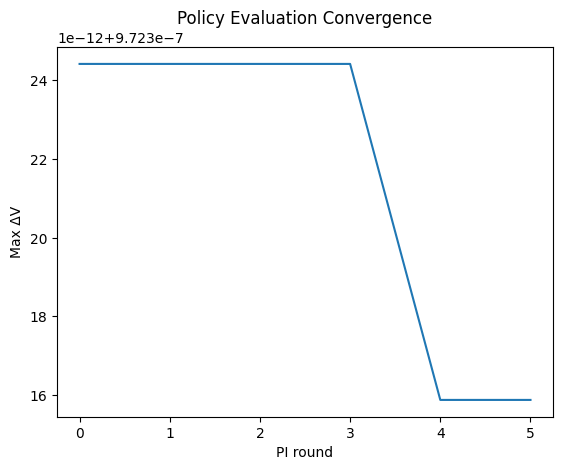

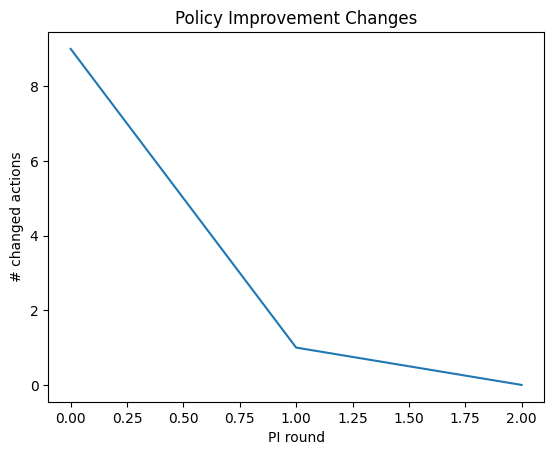

In [8]:
"""polylog_simplify_env.py
================================================
A **stand alone, zero dependency** Gym environment + a minimal **Policy Iteration (PI)** loop
so you can run an RL prototype end to end without installing PyTorch or Stable Baselines.

•  Environment  : `PolylogSimplifyEnv`
•  Agent        : `PolicyIterationAgent` (tabular PI)
•  Metrics      : Stores convergence `deltas` and `policy_changes` per PI round
•  Demo         : `python polylog_simplify_env.py` → builds dummy data, runs PI, prints and optionally plots metrics

Replace the dummy dataset with your real `onehot_data / token_to_id / id_to_token` to experiment on genuine expressions.
"""

from __future__ import annotations

import random
from typing import Dict, List, Tuple

import gym
import numpy as np
from gym import spaces
from sympy import symbols,Add, Mul,Pow, Function, sympify, simplify

# -----------------------------------------------------------------------------
#  Environment
# -----------------------------------------------------------------------------


class PolylogSimplifyEnv(gym.Env):
    """Toy environment that rewrites `polylog(2, x)` expressions."""

    metadata = {"render.modes": []}

    def __init__(
        self,
        onehot_data: np.ndarray,
        token_to_id: Dict[str, int],
        id_to_token: Dict[int, str],
    ):
        super().__init__()
        self.data = onehot_data  # [N, L_max, vocab]
        self.token_to_id = token_to_id
        self.id_to_token = id_to_token

        self.num_actions = 4
        self.max_steps = 50

        self.observation_space = spaces.Box(
            0.0, 1.0, shape=self.data.shape[1:], dtype=np.float32
        )
        self.action_space = spaces.Discrete(self.num_actions)

        # trackers
        self.current_step = 0
        self.idx = 0
        self.state: np.ndarray | None = None
        self.expr = None
        self.best_dilog_count = 0
        self.prev_action: int | None = None
        self.prev_dilog_count: int | None = None

    # -------- Gym API --------

    def reset(self):
        self.current_step = 0
        self.idx = np.random.randint(0, len(self.data))
        self.state = self.data[self.idx].copy()
        self.expr = self._onehot_to_expr(self.state)
        self.best_dilog_count = self._count_polylogs(self.expr)
        self.prev_action = None
        self.prev_dilog_count = self.best_dilog_count
        return self.state

    def step(self, action: int):
        self.current_step += 1

        new_expr = self._apply_action(self.expr, action)
        new_dilog_count = self._count_polylogs(new_expr)

        reward = 0.0
        if new_dilog_count < self.best_dilog_count:
            reward = 1.0
            self.best_dilog_count = new_dilog_count
        if (
            self.prev_action is not None
            and action == self.prev_action
            and new_dilog_count >= self.prev_dilog_count
        ):
            reward -= 0.1

        self.prev_action = action
        self.prev_dilog_count = new_dilog_count

        self.expr = new_expr
        self.state = self._expr_to_onehot(new_expr)

        done = self.current_step >= self.max_steps or self.best_dilog_count == 0
        return self.state, reward, done, {}

    # -------- helpers --------

    op_map = {
    'add': Add,
    'mul': Mul,
    'pow': Pow,
    'sin': Function('sin'),
    'cos': Function('cos'),
    'log': Function('log'),
    'polylog': Function('polylog'),
}


    def parse_prefix(tokens):
    """
    将前缀表达式（token 列表）转换为 sympy.Expr
    示例: ['add', 'mul', '2', 'x', '3'] => 2*x + 3
    """
    if not tokens:
        raise ValueError("Empty token list")

    token = tokens.pop(0)

    if token in op_map:
        # 二元运算符默认取两个操作数
        func = op_map[token]
        arg1 = parse_prefix(tokens)
        arg2 = parse_prefix(tokens)
        return func(arg1, arg2)
    elif token in context:
        return context[token]
    else:
        try:
            return sympify(token)
        except Exception as e:
            raise ValueError(f"Invalid token: {token}") from e


    def _apply_action(self, expr, action):
        # 作用于第一项
        # 记得使用函数之后进行简化操作
        try:
            if action == 0:  # reflection
                return simplify(expr.replace(
                    lambda f: f.func.__name__ == 'polylog',
                    lambda f: -Function('polylog')(2, 1 - f.args[1]) 
                              + (np.pi**2)/6 
                              - sympify("log(%s)*log(1-%s)" % (f.args[1], f.args[1])),
                    1))
            elif action == 1:  # inversion
                return simplify(expr.replace(lambda f: f.func.__name__ == 'polylog',
                                    lambda f: -Function('polylog')(2, 1/f.args[1]) - (np.pi**2)/6 - 0.5 * (sympify("log(-%s)" % f.args[1]))**2, 1))
            elif action == 2:  # duplication
                return simplify(expr.replace(lambda f: f.func.__name__ == 'polylog' and f.args[1].is_Pow and f.args[1].exp == 2,
                                    lambda f: 2 * Function('polylog')(2, f.args[1].base) + 2 * Function('polylog')(2, -f.args[1].base), 1))
            elif action == 3:  # cyclic (polylog 项随机重排)
                return simplify(self.shuffle_polylog_terms(expr))
        except Exception:
            return simplify(expr)

    @staticmethod
    def _shuffle_polylog(expr):
        try:
            if not isinstance(expr, Add):
                return expr
            terms = list(expr.args)
            pl_terms = [t for t in terms if t.has(Function("polylog"))]
            other = [t for t in terms if not t.has(Function("polylog"))]
            random.shuffle(pl_terms)
            return Add(*pl_terms, *other)
        except Exception:
            return expr

    def _onehot_to_expr(self, oh: np.ndarray):
        toks = [self.id_to_token.get(int(np.argmax(row)), "") for row in oh]
        try:
            return sympify(" ".join([t for t in toks if t]))
        except Exception:
            return sympify("0")

    def _expr_to_onehot(self, expr):
        try:
            from prefix_converter import generate_prefix
            from onehot_encoder import prefix_to_onehot

            prefix = generate_prefix(str(expr))
            return prefix_to_onehot(prefix)
        except Exception:
            return self.state

    @staticmethod
    def _count_polylogs(expr):
        try:
            return len(expr.atoms(Function).intersection({Function("polylog")}))
        except Exception:
            return 0


# -----------------------------------------------------------------------------
#  Policy‑Iteration Agent (tabular)
# -----------------------------------------------------------------------------


class PolicyIterationAgent:
    """Minimal Policy Iteration for small, finite MDPs. Records convergence metrics."""

    def __init__(self, env: PolylogSimplifyEnv, gamma: float = 0.95, theta: float = 1e-6):
        self.env = env
        self.gamma = gamma
        self.theta = theta
        self.policy: Dict[Tuple, int] = {}
        self.V: Dict[Tuple, float] = {}
        # metrics
        self.deltas: List[float] = []
        self.policy_changes: List[int] = []

    def _hash(self, s: np.ndarray) -> Tuple[int, ...]:
        return tuple(s.flatten().astype(int))

    # ---- core ----

    def _evaluate(self):
        while True:
            delta = 0.0
            for sk, act in list(self.policy.items()):
                self.env.state = np.array(sk, dtype=np.float32).reshape(self.env.state.shape)
                self.env.expr = self.env._onehot_to_expr(self.env.state)
                nxt, r, _, _ = self.env.step(act)
                vk = r + self.gamma * self.V.get(self._hash(nxt), 0.0)
                delta = max(delta, abs(vk - self.V.get(sk, 0.0)))
                self.V[sk] = vk
            if delta < self.theta:
                self.deltas.append(delta)
                break
        self.deltas.append(delta)

    def _improve(self):
        changes = 0
        for sk in list(self.policy.keys()):
            best_a, best_v = None, -np.inf
            for a in range(self.env.num_actions):
                self.env.state = np.array(sk, dtype=np.float32).reshape(self.env.state.shape)
                self.env.expr = self.env._onehot_to_expr(self.env.state)
                nxt, r, _, _ = self.env.step(a)
                v = r + self.gamma * self.V.get(self._hash(nxt), 0.0)
                if v > best_v:
                    best_a, best_v = a, v
            if best_a is not None and best_a != self.policy[sk]:
                changes += 1
                self.policy[sk] = best_a
        self.policy_changes.append(changes)
        return changes == 0

    def train(self, episodes: int = 10):
        # bootstrap random policy via rollouts
        for _ in range(episodes):
            st = self.env.reset()
            done = False
            while not done:
                k = self._hash(st)
                self.policy.setdefault(k, self.env.action_space.sample())
                st, _, done, _ = self.env.step(self.policy[k])

        rounds = 0
        while True:
            rounds += 1
            self._evaluate()
            if self._improve():
                break
        return rounds, len(self.policy)


# -----------------------------------------------------------------------------
#  Quick demo & plotting helpers
# -----------------------------------------------------------------------------


def _dummy_dataset(N: int = 120, L_max: int = 18, vocab: List[str] | None = None):
    vocab = vocab or ["add", "mul", "polylog", "+", "*", "x", "1", "2"]
    tok2id = {t: i for i, t in enumerate(vocab)}
    id2tok = {i: t for t, i in tok2id.items()}
    vsize = len(vocab)
    data = np.zeros((N, L_max, vsize), np.float32)
    for n in range(N):
        for i in range(L_max):
            data[n, i, np.random.randint(0, vsize)] = 1.0
    return data, tok2id, id2tok


def main(plot: bool = False):
    data = np.load("onehot_expressions.npy")
    # 定义词表
    vocab = ['add', 'mul', 'polylog', '+', '*', '**', 'x'] + [str(i) for i in range(-10, 10)]

    #token → id 映射
    token_to_id = t2i = {token: idx for idx, token in enumerate(vocab)}

    # id → token 映射（反向映射）
    d_to_token = i2t = {idx: token for token, idx in token_to_id.items()}

    env = PolylogSimplifyEnv(data, t2i, i2t)
    agent = PolicyIterationAgent(env)
    rounds, n_states = agent.train()
    print(f"PI converged in {rounds} rounds; |S| = {n_states}")
    print(
        f"Final delta: {agent.deltas[-1]:.3e}, total policy changes list: {agent.policy_changes}"
    )
    if plot:
        import matplotlib.pyplot as plt

        # delta curve
        plt.figure()
        plt.plot(agent.deltas)
        plt.xlabel("PI round")
        plt.ylabel("Max ΔV")
        plt.title("Policy Evaluation Convergence")

        # policy change curve
        plt.figure()
        plt.plot(agent.policy_changes)
        plt.xlabel("PI round")
        plt.ylabel("# changed actions")
        plt.title("Policy Improvement Changes")

        plt.show()


if __name__ == "__main__":
    main(plot=True)
